<h1><b>GSK NLP Analyst Technical Case Study</b><h1>

<h3>Christine C. Amuzie<h3>
Broader Impact Data Services

<i>Completed: 2021.12.10</i>

<i>Last Modified: 2021.12.10</i>

Select a drug from the dataset. Imagine that a leader for that product has asked you the following question: “What aspects do patients like about using our product, and what do people dislike?”
Use the data to write a report for this leader that will address their question.

In [2]:
# Checking versions
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

# Loading relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Setting visualization parameters 
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#Setting pytorch parameters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

numpy       : 1.19.2
pandas      : 1.2.2
torch       : 1.10.0
transformers: 4.13.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   uniqueID  1957 non-null   int64 
 1   drugName  1957 non-null   object
 2   review    1957 non-null   object
 3   date      1957 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.3+ KB


/Users/christineamuzie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


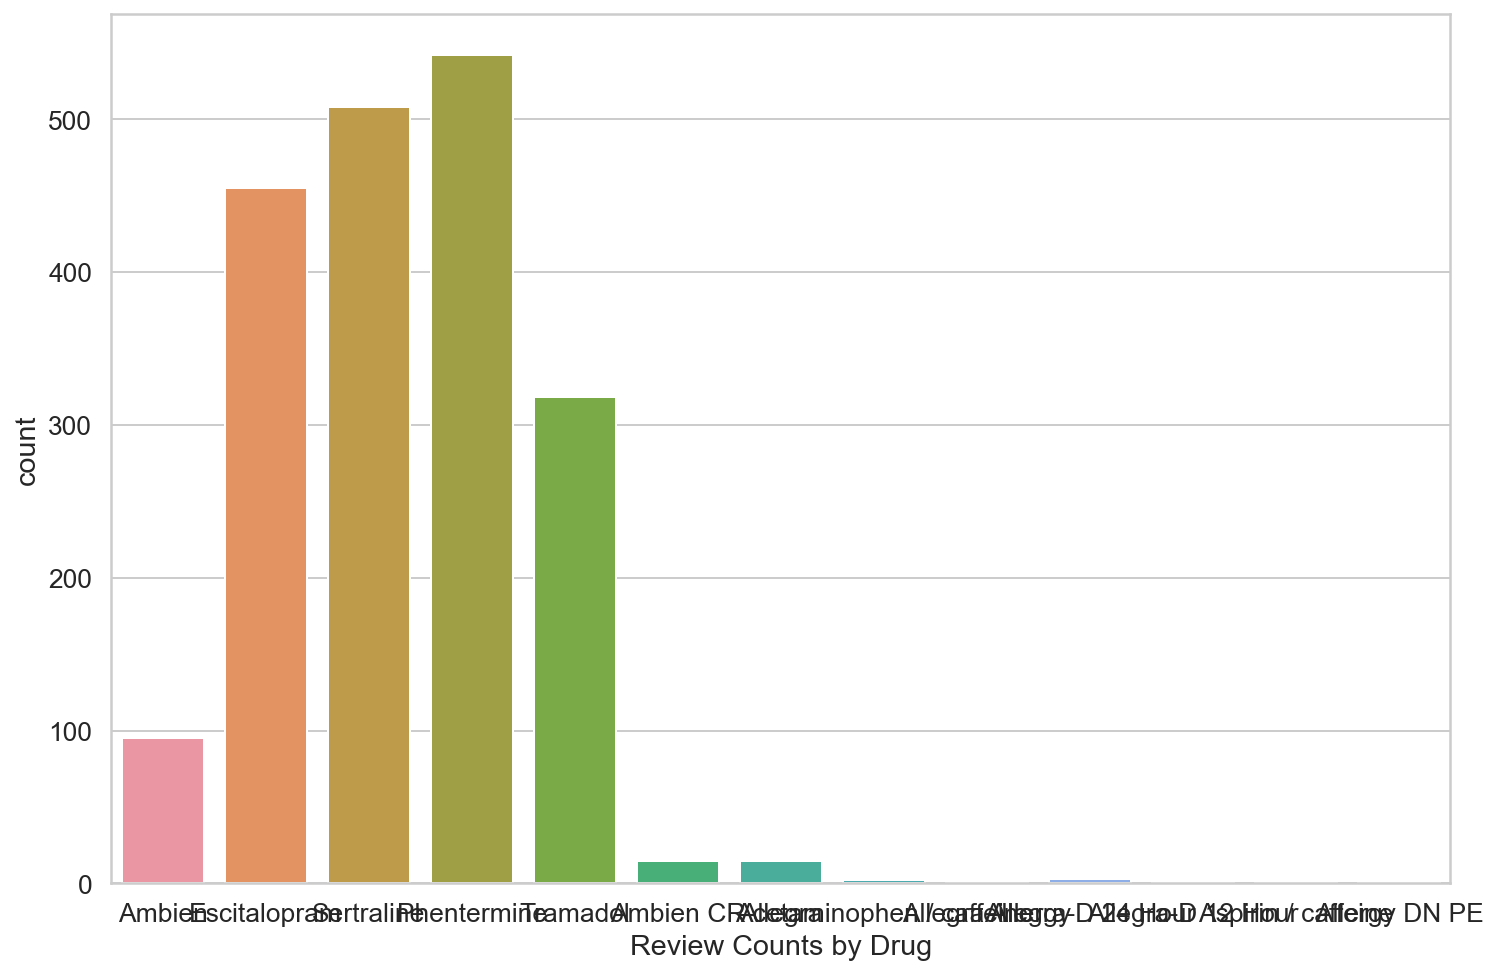

In [3]:
# Exploratory Data Analysis

df = pd.read_csv("case_study_data.txt", sep="\t", header=0)
df.head()
df.shape
df.info()
sns.countplot(df.drugName)
plt.xlabel('Review Counts by Drug');


In [4]:
# Data Preprocessing with BERT
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = "It's a new dawn, it's a new day, it's a new life for me. And I'm feeling good!"
# Tokenization
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

tokenizer.sep_token, tokenizer.sep_token_id # sentence ending separation
tokenizer.cls_token, tokenizer.cls_token_id # beginning sentences
tokenizer.pad_token, tokenizer.pad_token_id # padding
tokenizer.unk_token, tokenizer.unk_token_id # unknown

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=None,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

# dict_keys(['input_ids', 'attention_mask']) # dict_keys doesn't work for py3
vocab = list(df.keys(['input_ids', 'attention_mask']))

# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/



ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [10]:
# token ids
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1135,  112,  188,  170, 1207, 9623,  117, 1122,  112,  188,  170,
        1207, 1285,  117, 1122,  112,  188,  170, 1207, 1297, 1111, 1143,  119,
        1262,  146,  112,  182, 2296, 1363,  106,  102])

In [5]:
# determining max length of review
import numpy as np
measurer = np.vectorize(len)
res1 = measurer(df.values.astype(str)).max(axis=0)
print(res1)

[   6   24 2642    9]


Broader Impact Data Services, LLC &copy; 2021